# Generate training and validation sets of streaks images

In [1]:
import numpy as np
from numpy import random
from PIL import Image
from PIL import ImageDraw
from PIL import ImageOps
from PIL import ImageFilter
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

Fix random seed to make sure we get reproducible results.

In [2]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)

Define a class that is used to generate streak images, which we will use to produce our training/validation/test sets

In [3]:
class StreakImageGenerator:
    def __init__(self, windowSize, maxDisplacement, nparticles,\
                 radius, uRms, phiRms):
        self.winSz = windowSize
        self.maxDisplacement = maxDisplacement
        self.nparticles = nparticles
        self.radius = radius
        self.uRms = uRms
        self.phiRms = phiRms
        
    def generate(self, count = 1, sigma = None):
        images = np.zeros([count, 1, self.winSz, self.winSz], dtype=np.uint8)
        un0 = np.zeros(count, dtype=np.float32)
        phi0 = np.zeros(count, dtype=np.float32)
        
        img = Image.new('L', (self.winSz,self.winSz),(0))
        draw = ImageDraw.Draw(img)

        nstreaks = random.randint(self.nparticles.start, self.nparticles.stop, count)
        
        for i in range(0, count):
            draw.rectangle((0, 0, self.winSz, self.winSz), fill=(0)) # clean image
            
            un0[i] = np.sqrt(random.uniform(0, 1)) * self.maxDisplacement
            phi0[i] = random.uniform(0, np.pi) - np.pi / 2    
                        
            x_start = random.uniform(0, self.winSz, nstreaks[i])
            y_start = random.uniform(0, self.winSz, nstreaks[i])
        
            un = un0[i] + random.uniform(.0, self.uRms, nstreaks[i])
            phi = phi0[i] + random.uniform(-self.phiRms * np.pi / 180 / 2, self.phiRms * np.pi / 180 / 2, nstreaks[i])
            
            Dx = un * np.cos(phi)
            Dy = un * np.sin(phi)
            x_end = x_start + Dx 
            y_end = y_start + Dy 
            
            for j in range(nstreaks[i]):
                width = random.randint(self.radius.start, self.radius.stop)
                intensity = random.randint(200, 255)
                draw.line(((x_start[j], y_start[j]), \
                           (x_end[j], y_end[j])), fill=intensity, width=width)
                
            if sigma is None:
                images[i,0,:,:] = img;
            else:
                images[i,0,:,:] = img.filter(ImageFilter.GaussianBlur(radius=sigma))
                
        return images,un0,phi0*180/np.pi,nstreaks

Specify and generate training an validation sets

(array([ 99548., 100232., 100133., 100237., 100108.,  99703.,  99736.,
         99816., 100094., 100393.]),
 array([-8.9999680e+01, -7.1999725e+01, -5.3999771e+01, -3.5999821e+01,
        -1.7999866e+01,  8.7738037e-05,  1.8000042e+01,  3.5999996e+01,
         5.3999947e+01,  7.1999901e+01,  8.9999855e+01], dtype=float32),
 <a list of 10 Patch objects>)

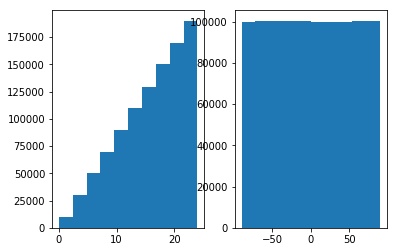

In [4]:
windowSize = 48
maxDisplacement = 24
nparticles = range(2, 10)
radius = range(1, 4)
uRms = 0
phiRms = 0

generator = StreakImageGenerator(windowSize, maxDisplacement, \
                                 nparticles, radius, uRms, phiRms)

count = 1000000;
images, Un, Phi, _ = generator.generate(count = count, sigma = 1)

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(Un)
ax = fig.add_subplot(1,2,2)
plt.hist(Phi)

Display random images and their parameters

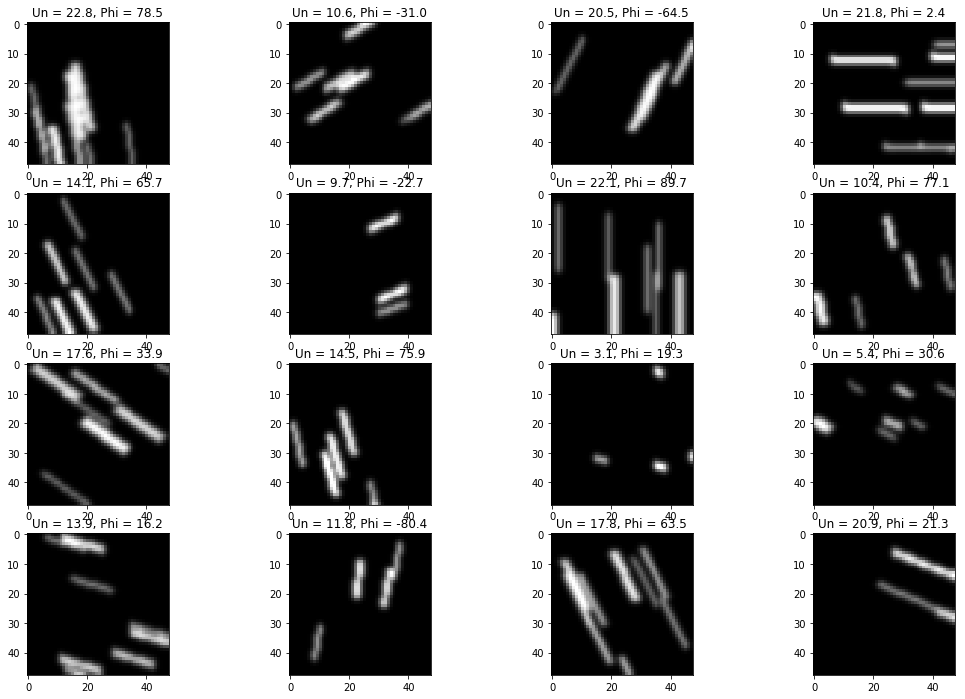

In [5]:
indices = random.randint(0, len(images), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(images[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (Un[indices[i]], Phi[indices[i]]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Save generated data

In [6]:
h5f = h5py.File('data/train_val_sets_n=1M.h5', 'w')
h5f.create_dataset('images', data=images, compression="gzip", compression_opts=6)
h5f.create_dataset('Un', data=Un, compression="gzip", compression_opts=6)
h5f.create_dataset('Phi', data=Phi, compression="gzip", compression_opts=6)
h5f.create_dataset('windowSize', data=windowSize)
h5f.create_dataset('maxDisplacement', data=maxDisplacement)
h5f.create_dataset('nparticles', data=nparticles)
h5f.create_dataset('radius', data=radius)
h5f.create_dataset('uRms', data=uRms)
h5f.create_dataset('phiRms', data=phiRms)

h5f.close()